# Multimodal Classification 

### Table of Contents

[A. Audio Data Cleaning](#datacleaning) <br>
[B. Exploratory Data Analysis](#eda) <br>
[C. Audio Preprocessing](#preprocessing) <br>
[D. Feature Extraction](#featureextraction) <br>
[E. Model Training and Evaluation - Individual Models](#individualmodels) <br>
[F. Model Training and Evaluation - Multimodal Model](#multimodalmodels) <br> 


**Import libraries**

In [15]:
import os
import glob
import shutil
import tarfile
import random
from collections import Counter
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa, librosa.display
import tensorflow as tf
import soundfile as sf
import IPython.display as ipd
import noisereduce as nr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models

## <a id='datacleaning'></a> A. Audio Data Cleaning

### 1. Extract audio data

Extract the audio data in WAV format that are stored in the TAR files. This script creates an Extracted_data folder containing all the WAV files in the directories date-wise. Each extracted folder in the format YYYYMMDD contains additional 2,746 folders, labeled with the participant ID, containing the nine sound category files and a metadata file.

**Extract audio files from TAR**

In [16]:
# Define path
coswara_data_dir =r"E:\DANA4850-Capstone\Data\1 Coswara-Data"
extracted_data_dir = os.path.join(coswara_data_dir, 'Extracted_data')

if not os.path.exists(coswara_data_dir):
    raise ("Check the Coswara dataset directory!")

if not os.path.exists(extracted_data_dir):
    os.makedirs(extracted_data_dir) # Create the Extracted_data folder if it doesn't exist

# List directories to extract
dirs_extracted = set(map(os.path.basename,glob.glob('{}/202*'.format(extracted_data_dir))))
dirs_all = set(map(os.path.basename,glob.glob('{}/202*'.format(coswara_data_dir))))
dirs_to_extract = list(set(dirs_all) - dirs_extracted) 

# Extract WAV audio from TAR files in each directory  
for directory in dirs_to_extract:
    # List all parts of the tar.gz file
    parts = sorted(glob.glob(os.path.join(coswara_data_dir, directory, '*.tar.gz.*')))

    if parts:
        concatenated_file_path = os.path.join(extracted_data_dir, f"{directory}.tar.gz")
        
        # Concatenate parts into a single tar.gz file
        with open(concatenated_file_path, 'wb') as concatenated_file:
            for part in parts:
                with open(part, 'rb') as part_file:
                    concatenated_file.write(part_file.read())
        
        # Extract the concatenated tar.gz file
        try:
            with tarfile.open(concatenated_file_path, 'r:gz') as tar:
                tar.extractall(path=extracted_data_dir)
            print(f"Successfully extracted {directory}")
        except Exception as e:
            print(f"Error extracting {directory}: {e}")
        
        # Delete the concatenated tar.gz file after extraction
        os.remove(concatenated_file_path)


Successfully extracted 20200417
Successfully extracted 20200919
Successfully extracted 20200930
Successfully extracted 20201012
Successfully extracted 20200720
Successfully extracted 20201130
Successfully extracted 20201221
Successfully extracted 20200901
Successfully extracted 20210406
Successfully extracted 20200416
Successfully extracted 20200814
Successfully extracted 20220224
Successfully extracted 20210830
Successfully extracted 20210603
Successfully extracted 20200505
Successfully extracted 20200413
Successfully extracted 20200419
Successfully extracted 20210816
Successfully extracted 20200502
Successfully extracted 20200418
Successfully extracted 20200415
Successfully extracted 20200424
Successfully extracted 20200824
Successfully extracted 20200911
Successfully extracted 20210507
Successfully extracted 20200504
Successfully extracted 20210914
Successfully extracted 20200430
Successfully extracted 20201031
Successfully extracted 20210630
Successfully extracted 20210930
Successf

**Move all participant folders to main "Extracted_data" directory**

In [23]:
source_path = r"E:\DANA4850-Capstone\Data\1 Coswara-Data\Extracted_data"

# Move all participant folders to main directory
for root, dirs, files in os.walk(source_path):
    for dir_name in dirs:
        dates_dir = os.path.join(root, dir_name) # Date folders
        for sub_dir_name in os.listdir(dates_dir):
            participants_dir = os.path.join(dates_dir, sub_dir_name) # Participants folders
            shutil.move(participants_dir, os.path.join(source_path, sub_dir_name))

# Remove empty subdirectories (date folders)
for root, dirs, files in os.walk(source_path, topdown=False):
    for dir_name in dirs:
        dates_dir = os.path.join(root, dir_name) 
        if dir_name.startswith("202"): # Date folders
            os.rmdir(dates_dir)

### 2. Retain breathing and cough audio files

Coughing and shortness of breath are among the early mild symptoms of COVID-19 that have been utilized to aid in the preliminary diagnosis of the disease (Meysam Effati 2021), hence retain only the audio files for the four categories related to coughing and breathing.


**Delete other audio files**

In [24]:
files_retained = ['breathing-deep.wav', 'breathing-shallow.wav', 'cough-heavy.wav', 'cough-shallow.wav']

for root, dirs, files in os.walk(source_path):
    for file in files:
        if file not in files_retained: # Delete file if not in list
            file_path = os.path.join(root, file)
            os.remove(file_path)

**Rename audio files**

Rename all remaining respiratory sound files to include the participant ID and the corresponding sound category (e.g., 3l8trtOxHWOmdBh9WI5HgaVcAyi1_breathing-deep.wav).

In [25]:
for root, dirs, files in os.walk(source_path):
    id = os.path.basename(root) # Get ID from folder name
    # Include ID in audio file names
    for file in files:
        os.rename(os.path.join(root, file), os.path.join(root, "{}_{}".format(id, file)))

### 3. Remove poor quality audio files

The entire respiratory dataset has been manually annotated with quality labels on a scale of 0-2, where listeners classified the recordings as 0 for poor quality (significant ambient noise), 1 for moderate quality (slight ambient noise), and 2 for excellent quality (no ambient noise). Retain only the audio files classified as having moderate (1) and excellent (2) quality.

**Move all audio files to main "Extracted_data" directory**

In [26]:
# Move all files to main folder
for root, dirs, files in os.walk(source_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        shutil.move(file_path, os.path.join(source_path, file_name))

# Remove empty subdirectories
for root, dirs, files in os.walk(source_path, topdown=False):
    for dir in dirs:
        os.rmdir(os.path.join(root, dir))

**Move breathing and cough audio files to corresponding folders**

In [29]:
# Define the destination folders
destination_folders = {
    '*breathing-deep.wav': os.path.join(source_path, 'breathing-deep'),
    '*breathing-shallow.wav': os.path.join(source_path, 'breathing-shallow'),
    '*cough-heavy.wav': os.path.join(source_path, 'cough-heavy'),
    '*cough-shallow.wav': os.path.join(source_path, 'cough-shallow')
}

for audio_type, destination in destination_folders.items():
    os.makedirs(destination, exist_ok=True) # Create destination folder if it doesn't exist
    files = glob.glob(os.path.join(source_path, audio_type)) # Find files matching the pattern
    
    # Move matching files to appropriate destination folders
    for file in files:
        shutil.move(file, os.path.join(destination, os.path.basename(file)))

**Create dataframes of the audio annotations**

In [30]:
csv_path = r"E:\DANA4850-Capstone\Data\1 Coswara-Data\annotations"

dataframes_dict = {}
for csv in os.listdir(csv_path):
    # Extract filename without extension to use as df name
    df_name = os.path.splitext(csv)[0]

    # Read CSV file into a df
    file_path = os.path.join(csv_path, csv)
    df = pd.read_csv(file_path)

    # Store df in the dictionary
    dataframes_dict[df_name] = df

# Access df
for name, df in dataframes_dict.items():
    print("\033[1m" + f"{name}:" + "\033[0m")
    display(df.head(2))


breathing-deep_labels:


FILENAME   QUALITY
0  vK2bLRNzllXNeyOMudnNSL5cfpG2_breathing-deep         2
1  bjA2KpSxneNskrLBeqi4bqoTDQl2_breathing-deep         2

breathing-shallow_labels:


FILENAME   QUALITY
0  vK2bLRNzllXNeyOMudnNSL5cfpG2_breathing-shallow         2
1  bjA2KpSxneNskrLBeqi4bqoTDQl2_breathing-shallow         2

cough-heavy_labels:


FILENAME   QUALITY
0  vK2bLRNzllXNeyOMudnNSL5cfpG2_cough-heavy         2
1  bjA2KpSxneNskrLBeqi4bqoTDQl2_cough-heavy         2

cough-shallow_labels:


FILENAME   QUALITY
0  vK2bLRNzllXNeyOMudnNSL5cfpG2_cough-shallow         2
1  bjA2KpSxneNskrLBeqi4bqoTDQl2_cough-shallow         2

**Select and delete files with poor audio quality (QUALITY == 0)**

In [38]:
files_to_delete_dict = {}

# Iterate through the dictionary of DataFrames
for name, df in dataframes_dict.items():
    df.columns = df.columns.str.strip() # Remove leading and trailing whitespaces
    df_to_delete = df[df['QUALITY'] == 0]
    files_to_delete_dict[name.replace("_labels", "")] = df_to_delete

# Access df
for name, df in files_to_delete_dict.items():
    print(f"{name}: {df.shape[0]} files")

breathing-deep: 452 files
breathing-shallow: 472 files
cough-heavy: 210 files
cough-shallow: 181 files


In [42]:
source_path = r"E:\DANA4850-Capstone\Data\1 Coswara-Data\Extracted_data"
audio_folders = {
    'breathing-deep': os.path.join(source_path, 'breathing-deep'),
    'breathing-shallow': os.path.join(source_path, 'breathing-shallow'),
    'cough-heavy': os.path.join(source_path, 'cough-heavy'),
    'cough-shallow': os.path.join(source_path, 'cough-shallow')
}

for df_name, folder_path in audio_folders.items():
     # Get corresponding dataframe
    if df_name in files_to_delete_dict:
        df = files_to_delete_dict[df_name]

        # Iterate through filenames in the dataframe
        for filename in df['FILENAME']:
            file_path = os.path.join(folder_path, filename + '.wav')
            if os.path.exists(file_path):
                os.remove(file_path) # Delete poor quality file

### 4. Filter data based on patient information

Retain participant with **age within 18-80 years old**, based on the following classes:

**neg_no_illness** - no COVID, no respiratory illness, no COVID-like symptoms, no comorbidity

**neg_with_illness** - no COVID, with respiratory illness, with COVID-like symptoms, with comorbidity

**pos_asymp_mild** - positive asymptomatic/mild cases

**pos_asymp_mod** - positive moderate cases


**Select IDs from combined_data_filter.csv**

In [140]:
df = pd.read_csv(r"E:\DANA4850-Capstone\Data\1 Coswara-Data\combined_data_filter.csv")
df

id   a       covid_status record_date ep   
0     iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28            healthy  2020-04-23  y  \
1     AxuYWBN0jFVLINCBqIW5aZmGCdu1  25            healthy  2020-04-20  y   
2     C5eIsssb9GSkaAgIfsHMHeR6fSh1  28            healthy  2020-04-24  y   
3     YjbEAECMBIaZKyfqOvWy5DDImUb2  26            healthy  2020-04-23  y   
4     aGOvk4ji0cVqIzCs1jHnzlw2UEy2  32            healthy  2020-04-22  y   
...                            ...  ..                ...         ... ..   
2058  333NjqA1TfZJuICEdXSkPhVz0LA3  48     positive_asymp  2021-07-13  y   
2059  dpA0EeRrtJUeKJjEuf7BL0AeTJZ2  36      positive_mild  2021-07-06  y   
2060  UXhG3vgoxkWtd4Meky1nm0sRgMV2  76      positive_mild  2021-07-13  y   
2061  A5KW9PXraNgckln1gnNaJnX6DvB2  25  positive_moderate  2021-07-01  y   
2062  iYwmYc9CdlSuzqGwIlXNWI6eFpm1  78      positive_mild  2021-07-06  y   

           g            l_c              l_l             l_s rU  ...   bd   
0       male          India        Anantapur  Andhra Pradesh  n  ...  NaN  \
1       male          India  BENGALURU URBAN       Karnataka  n  ...  NaN   
2     female  United States       Pittsburgh    Pennsylvania  n  ...  NaN   
3       male          India        Bangalore       Karnataka  n  ...  NaN   
4       male          India          Nalanda           Bihar  n  ...  NaN   
...      ...            ...              ...             ... ..  ...  ...   
2058    male          India     Thondamuthur      Tamil Nadu  n  ...  NaN   
2059    male          India            MSRMC       Karnataka  n  ...  NaN   
2060    male          India       Coimbatore      Tamil Nadu  n  ...  NaN   
2061    male          India       Coimbatore      Tamil Nadu  n  ...  NaN   
2062  female          India            Msrmc       Karnataka  n  ...  NaN   

     others_resp   ftg   st  ihd asthma others_preexist  cld pneumonia   
0            NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN  \
1            NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN   
2            NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN   
3            NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN   
4            NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN   
...          ...   ...  ...  ...    ...             ...  ...       ...   
2058         NaN  True  NaN  NaN    NaN             NaN  NaN       NaN   
2059         NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN   
2060         NaN  True  NaN  NaN    NaN             NaN  NaN       NaN   
2061         NaN   NaN  NaN  NaN    NaN             NaN  NaN       NaN   
2062         NaN  True  NaN  NaN    NaN             NaN  NaN       NaN   

                status  
0       neg_no_illness  
1       neg_no_illness  
2       neg_no_illness  
3     neg_with_illness  
4       neg_no_illness  
...                ...  
2058    pos_asymp_mild  
2059    pos_asymp_mild  
2060    pos_asymp_mild  
2061           pos_mod  
2062    pos_asymp_mild  

[2063 rows x 37 columns]

**Delete files not included in selected IDs**

In [142]:
valid_ids = df['id'].astype(str).tolist()

In [143]:
for df_name, folder_path in audio_folders.items():
    for filename in os.listdir(folder_path):
        # Extract ID from filename
        file_id = filename.split('_')[0]
        
        # Delete file if ID is not in valid_id list
        if file_id not in valid_ids:
            os.remove(os.path.join(folder_path, filename))

## <a id='eda'></a> B. Exploratory Data Analysis

**Define paths**

In [4]:
source_path = r"E:\DANA4850-Capstone\Data\1 Coswara-Data\Extracted_data"
cough_data_dict = {
    'cough-heavy': os.path.join(source_path, 'cough-heavy'),
    'cough-shallow': os.path.join(source_path, 'cough-shallow')}

breath_data_dict = {
    'breathing-deep': os.path.join(source_path, 'breathing-deep'),
    'breathing-shallow': os.path.join(source_path, 'breathing-shallow'),}

### 1. Sample Rate

**Sample rate** is the number of samples per second taken from an audio waveform to create a discete digital signal. It is measured in kilohertz (kHz) and it determines the range of frequencies captured in digital audio.

**Cough Data**

In [146]:
# Initialize dictionary to store sample rates
sample_rate_cough_dict = {key: [] for key in cough_data_dict}

for key, path in cough_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        sample_rate = librosa.get_samplerate(file_path)
        sample_rate_cough_dict[key].append(sample_rate)

cough-heavy:Sample rate [48000, 44100, 192000, 16000], Count [1789, 132, 2, 9]
cough-shallow:Sample rate [48000, 44100, 192000, 16000], Count [1799, 128, 2, 8]


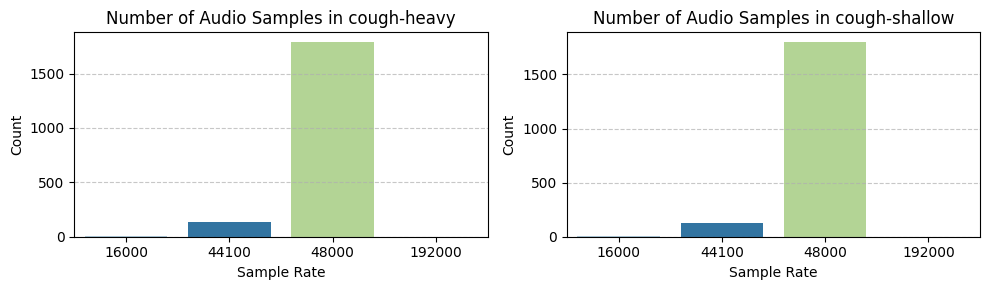

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Iterate over the dictionary items and plot in each subplot
for (key, sample_rates), ax in zip(sample_rate_cough_dict.items(), axes.flatten()):
    # Use Counter to count occurrences of each unique value
    counts = Counter(sample_rates)
    
    # Extract unique values and their counts
    unique_values = list(counts.keys())
    counts_values = list(counts.values())

    print("\033[1m" + f"{key}:" + "\033[0m" + f"Sample rate {unique_values}, Count {counts_values}")
    
    # Create bar plot using Seaborn
    sns.barplot(x=unique_values, y=counts_values, palette="Paired", ax=ax)
    ax.set_xlabel("Sample Rate")
    ax.set_ylabel("Count")
    ax.set_title(f"Number of Audio Samples in {key}")
    ax.tick_params(axis="x")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Majority of the audio files were recorded at 48 kHz (92.7%), while a few were recorded at 44.1 kHz (6.7%), 192 kHz (0.1%), and 16 kHz (0.4%). 

**Breathing Data**

In [148]:
# Initialize dictionary to store sample rates
sample_rate_breath_dict = {key: [] for key in breath_data_dict}

for key, path in breath_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        sample_rate = librosa.get_samplerate(file_path)
        sample_rate_breath_dict[key].append(sample_rate)

breathing-deep:Sample rate [48000, 44100, 192000, 16000], Count [1621, 132, 2, 8]
breathing-shallow:Sample rate [48000, 44100, 192000, 16000], Count [1595, 131, 2, 10]


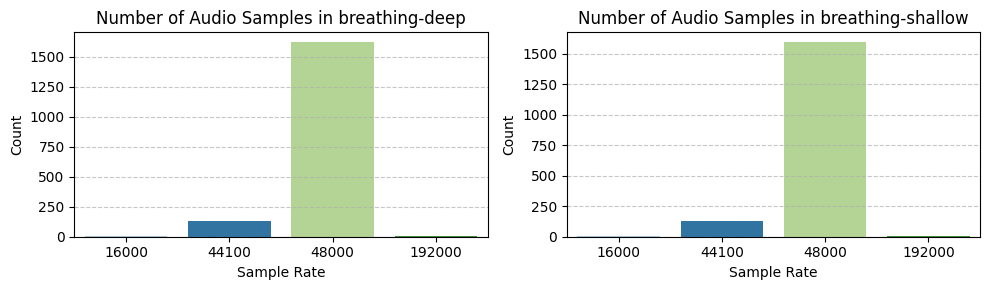

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Iterate over the dictionary items and plot in each subplot
for (key, sample_rates), ax in zip(sample_rate_breath_dict.items(), axes.flatten()):
    # Use Counter to count occurrences of each unique value
    counts = Counter(sample_rates)
    
    # Extract unique values and their counts
    unique_values = list(counts.keys())
    counts_values = list(counts.values())

    print("\033[1m" + f"{key}:" + "\033[0m" + f"Sample rate {unique_values}, Count {counts_values}")
    
    # Create bar plot using Seaborn
    sns.barplot(x=unique_values, y=counts_values, palette='Paired', ax=ax)
    ax.set_xlabel('Sample Rate')
    ax.set_ylabel('Count')
    ax.set_title(f'Number of Audio Samples in {key}')
    ax.tick_params(axis='x')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Majority of the audio files were recorded at 48 kHz (91.9%), while a few were recorded at 44.1 kHz (7.5%), 192 kHz (0.1%), and 16 kHz (0.5%). 

### 2. Duration

**Cough Data**

In [150]:
# Initialize dictionary to store sample rates
dur_cough_dict = {key: [] for key in cough_data_dict}

for key, path in cough_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        duration = librosa.get_duration(path=file_path)
        dur_cough_dict[key].append(duration)

print("\033[1m" + f"Audio duration (in seconds)" + "\033[0m")
for key, dur in dur_cough_dict.items():
    print(f"{key}: {round(sum(dur_cough_dict[key])/len(dur_cough_dict[key]),2)} (ave), {round(min(dur_cough_dict[key]),2)} (min), {round(max(dur_cough_dict[key]),2)} (max)")

Audio duration (in seconds)
cough-heavy: 6.08 (ave), 0.0 (min), 30.04 (max)
cough-shallow: 5.37 (ave), 0.0 (min), 29.95 (max)


The audio files last for about 5 to 6 seconds on average, but ranged from around 0 to 30 seconds in total length.

In [159]:
# Identify audio files with 0 length
cough_to_delete = []
for key, path in cough_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        duration = librosa.get_duration(path=file_path)
        if duration == 0:
            cough_to_delete.append(file)
cough_to_delete

['C7Km0KttQRMMM6UoyocajfgZAOB3_cough-heavy.wav',
 'kgjTguvo3vZJTO7F1qO9GxEicbA3_cough-heavy.wav',
 'C7Km0KttQRMMM6UoyocajfgZAOB3_cough-shallow.wav']

In [160]:
# Delete audio files with 0 length
for root, dirs, files in os.walk(source_path):
    for file in files:
        if file in cough_to_delete:
            file_path = os.path.join(root, file)
            os.remove(file_path)

In [161]:
# Initialize dictionary to store sample rates
dur_cough_dict = {key: [] for key in cough_data_dict}

for key, path in cough_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        duration = librosa.get_duration(path=file_path)
        dur_cough_dict[key].append(duration)

print("\033[1m" + f"Audio duration (in seconds)" + "\033[0m")
for key, dur in dur_cough_dict.items():
    print(f"{key}: {round(sum(dur_cough_dict[key])/len(dur_cough_dict[key]),2)} (ave), {round(min(dur_cough_dict[key]),2)} (min), {round(max(dur_cough_dict[key]),2)} (max)")

Audio duration (in seconds)
cough-heavy: 6.09 (ave), 1.58 (min), 30.04 (max)
cough-shallow: 5.38 (ave), 1.45 (min), 29.95 (max)


The audio files last for about 5 to 6 seconds on average, but ranged from around 1 to 30 seconds in total length.

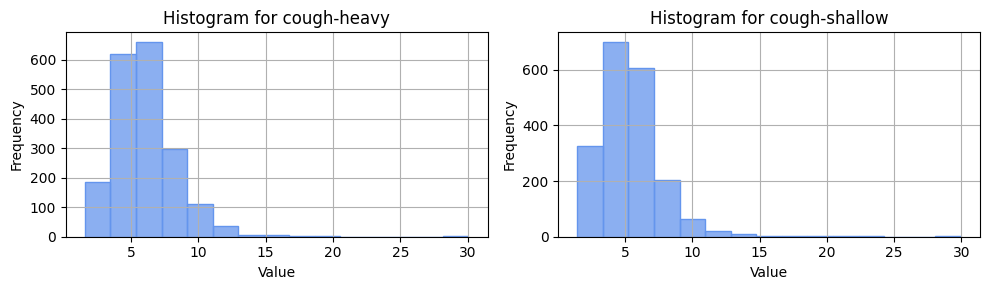

In [191]:
# Visualize in a histogram
fig, axes = plt.subplots(nrows=1, ncols=len(dur_cough_dict), figsize=(10, 3))

for idx, (key, values) in enumerate(dur_cough_dict.items()):
    sns.histplot(values, bins=15, kde=False, color='cornflowerblue', edgecolor='cornflowerblue', ax=axes[idx])
    axes[idx].set_title(f'Histogram for {key}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

**Breathing Data**

In [151]:
# Initialize dictionary to store sample rates
dur_breath_dict = {key: [] for key in breath_data_dict}

for key, path in breath_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        duration = librosa.get_duration(path=file_path)
        dur_breath_dict[key].append(duration)

print("\033[1m" + f"Audio duration (in seconds)" + "\033[0m")
for key, dur in dur_breath_dict.items():
    print(f"{key}: {round(sum(dur_breath_dict[key])/len(dur_breath_dict[key]),2)} (ave), {round(min(dur_breath_dict[key]),2)} (min), {round(max(dur_breath_dict[key]),2)} (max)")

Audio duration (in seconds)
breathing-deep: 17.01 (ave), 1.67 (min), 30.04 (max)
breathing-shallow: 10.67 (ave), 0.0 (min), 43.28 (max)


The audio files last for about 10 to 17 seconds on average, but ranged from around 0 to 43 seconds in total length.

In [154]:
# Identify audio files with 0 length
breath_to_delete = []
for key, path in breath_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        duration = librosa.get_duration(path=file_path)
        if duration == 0:
            breath_to_delete.append(file)
breath_to_delete

['C7Km0KttQRMMM6UoyocajfgZAOB3_breathing-shallow.wav',
 'kgjTguvo3vZJTO7F1qO9GxEicbA3_breathing-shallow.wav']

In [158]:
# Delete audio files with 0 length
for root, dirs, files in os.walk(source_path):
    for file in files:
        if file in breath_to_delete:
            file_path = os.path.join(root, file)
            os.remove(file_path)

In [162]:
# Initialize dictionary to store sample rates
dur_breath_dict = {key: [] for key in breath_data_dict}

for key, path in breath_data_dict.items():
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        duration = librosa.get_duration(path=file_path)
        dur_breath_dict[key].append(duration)

print("\033[1m" + f"Audio duration (in seconds)" + "\033[0m")
for key, dur in dur_breath_dict.items():
    print(f"{key}: {round(sum(dur_breath_dict[key])/len(dur_breath_dict[key]),2)} (ave), {round(min(dur_breath_dict[key]),2)} (min), {round(max(dur_breath_dict[key]),2)} (max)")

Audio duration (in seconds)
breathing-deep: 17.01 (ave), 1.67 (min), 30.04 (max)
breathing-shallow: 10.69 (ave), 2.05 (min), 43.28 (max)


The audio files last for about 10 to 17 seconds on average, but ranged from around 1 to 43 seconds in total length.

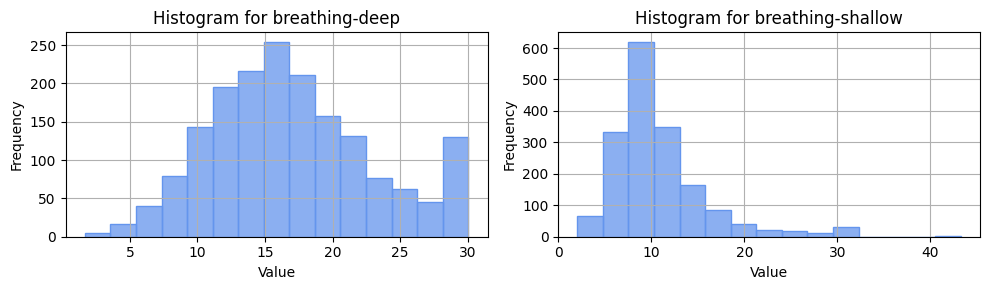

In [190]:
# Visualize in a histogram
fig, axes = plt.subplots(nrows=1, ncols=len(dur_breath_dict), figsize=(10, 3))

for idx, (key, values) in enumerate(dur_breath_dict.items()):
    sns.histplot(values, bins=15, kde=False, color='cornflowerblue', edgecolor='cornflowerblue', ax=axes[idx])
    axes[idx].set_title(f'Histogram for {key}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

### 3. Channel

A **channel** is a representation of sound coming from or going to a single point and a digital audio file can contain multiple channels of data.

***Monophonic*** (mono for short) means "one sound" - it has a single audio channel for playback (i.e., all elements of an audio combine and play through the same single channel at the same volume).

***Stereo*** sound, on the other hand, uses two audio channels - the left and the right - which creates a more realistic and immersive listening experience.

**Cough Data**

In [163]:
for key, path in cough_data_dict.items():
    # Initialize counters for mono and stereo audio files
    mono_count = 0
    stereo_count = 0
    
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        signal, sampling_rate = librosa.load(file_path, sr=None, mono=False)
        
        # Check if the audio is mono or stereo
        if signal.ndim == 1:
            mono_count += 1
        elif signal.ndim > 1:
            stereo_count += 1
        else:
            print(f"Unknown number of channels for file '{file}'.")

    print("\033[1m" + f"{key}" + "\033[0m")
    print("Mono:", mono_count)
    print("Stereo:", stereo_count)

cough-heavy
Mono: 1930
Stereo: 0
cough-shallow
Mono: 1936
Stereo: 0


All audio samples have a single audio channel for playback (monophonic).

**Breathing Data**

In [164]:
for key, path in breath_data_dict.items():
    # Initialize counters for mono and stereo audio files
    mono_count = 0
    stereo_count = 0
    
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        signal, sampling_rate = librosa.load(file_path, sr=None, mono=False)
        
        # Check if the audio is mono or stereo
        if signal.ndim == 1:
            mono_count += 1
        elif signal.ndim > 1:
            stereo_count += 1
        else:
            print(f"Unknown number of channels for file '{file}'.")

    print("\033[1m" + f"{key}" + "\033[0m")
    print("Mono:", mono_count)
    print("Stereo:", stereo_count)

breathing-deep
Mono: 1763
Stereo: 0
breathing-shallow
Mono: 1736
Stereo: 0


All audio samples have a single audio channel for playback (monophonic).

### 4. Visualize Audio as Waveform

A **waveform** is a graphical representation of a signal in the form of a wave and displays amplitude or level changes over time.

**Cough Data**

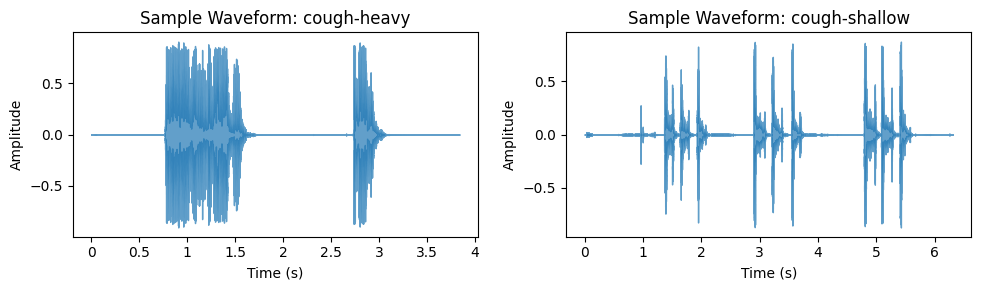

In [168]:
# random.seed(7)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i, (key, path) in enumerate(cough_data_dict.items()):
    file = random.choice(os.listdir(path))  # Select a random audio file
    file_path = os.path.join(path, file)
    
    # Load audio file
    signal, sampling_rate = librosa.load(file_path, sr=None, mono=False)

    # Play audio file
    display(ipd.Audio(file_path, rate=sampling_rate))

    # Plot waveform
    librosa.display.waveshow(y=signal, sr=sampling_rate, ax=axes[i], alpha=0.7)
    
    # Customize the subplot
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude")
    axes[i].set_title(f"Sample Waveform: {key}")

plt.tight_layout()
plt.show()

**Breathing Data**

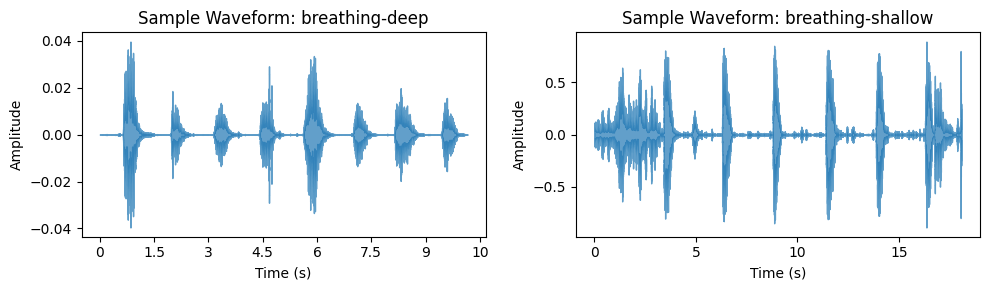

In [169]:
# random.seed(7)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i, (key, path) in enumerate(breath_data_dict.items()):
    file = random.choice(os.listdir(path))  # Select a random audio file
    file_path = os.path.join(path, file)
    
    # Load audio file
    signal, sampling_rate = librosa.load(file_path, sr=None, mono=False)

    # Play audio file
    display(ipd.Audio(file_path, rate=sampling_rate))

    # Plot waveform
    librosa.display.waveshow(y=signal, sr=sampling_rate, ax=axes[i], alpha=0.7)
    
    # Customize the subplot
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude")
    axes[i].set_title(f"Sample Waveform: {key}")

plt.tight_layout()
plt.show()

## <a id='preprocessing'></a> C. Audio Preprocessing

An audio preprocessing function covering the following preprocessing steps will be defined later:

**Channel**
- Since all the audio files were monophonic, there is no need to standardize and convert channels.

**Sampling Rate**
- The audio files were recorded at three different sampling rates (majority were at 48 kHz, few were 44.1 kHz, 192kHz, and 16 kHz), therefore sampling rates were standardized to 16 kHz to ensure data consistency and computational efficiency.

**Leading and Trailing Silence**
- From the EDA, it can be seen that the audio files have varying lengths, some with periods of silence at the beginning and end. To improve training efficiency and reduce irrelevant data, leading and trailing silence are removed in each audio file.

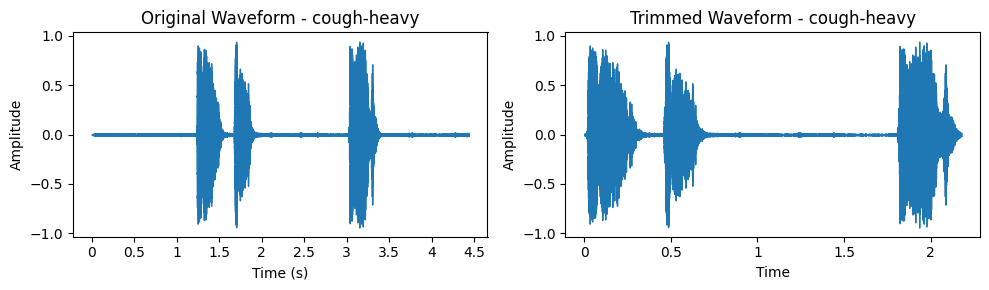

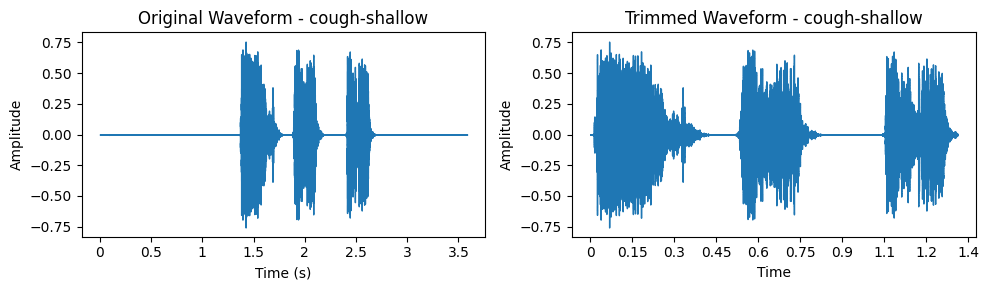

In [184]:
# Sample audio
for key, path in cough_data_dict.items():
    file = random.choice(os.listdir(path))  # Select a random audio file
    file_path = os.path.join(path, file)

    # Load audio file
    signal, sampling_rate = librosa.load(file_path, sr=None, mono=False)

    # Trim leading and trailing silences
    signal_t, index = librosa.effects.trim(signal, top_db=30)

    # Display the waveforms and audio
    plt.figure(figsize=(10, 3))

    # Plot the original waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y=signal, sr=sampling_rate)
    plt.title(f'Original Waveform - {key}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Play original audio file
    display(ipd.Audio(signal, rate=sampling_rate))

    # Plot the trimmed waveform
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(y=signal_t, sr=sampling_rate)
    plt.title(f'Trimmed Waveform - {key}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Play trimmed audio
    display(ipd.Audio(signal_t, rate=sampling_rate))

    plt.tight_layout()
    plt.show()


**Noise reduction**

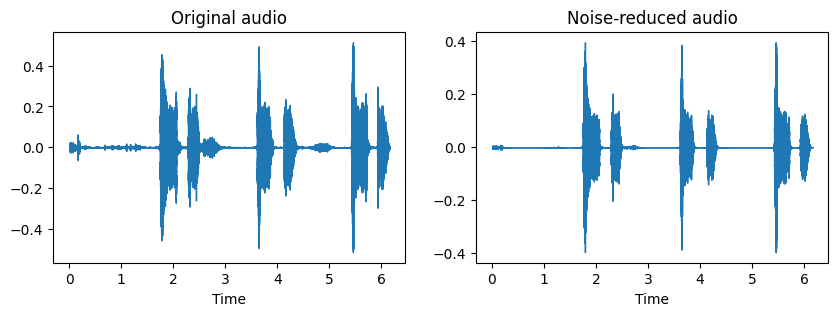

In [421]:
# Sample audio
sample = r'E:\DANA4850-Capstone\Data\1 Coswara-Data\Extracted_data\Cough\Train\00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav'
y, sr = librosa.load(sample, sr=48000, mono=True)
y_t, index = librosa.effects.trim(y, top_db=30)
y_n = nr.reduce_noise(y = y_t, sr=sr, n_std_thresh_stationary=1.5, stationary=True)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1) 
librosa.display.waveshow(y_t, sr=sr)
plt.title("Original audio")
plt.subplot(1, 2, 2)
plt.title("Noise-reduced audio")
librosa.display.waveshow(y_n, sr=sr)

**Average audio length**

Determine average audio length. This parameter will be used to standardize the length of audio samples prior to generating spectrograms and MFCCs.

In [ ]:
# Define paths
path_dict = {
    'cough_path': r"E:\DANA4850-Capstone\Data\1 Coswara-Data\Extracted_data\Cough",
    'breath_path': r"E:\DANA4850-Capstone\Data\1 Coswara-Data\Extracted_data\Breathing"}

In [ ]:
# Initialize dictionary to store duration
duration_dict = {key: [] for key in path_dict}

for key, path in path_dict.items():
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            y, sr = librosa.load(file_path, sr=22000, mono=True)
            y_t, index = librosa.effects.trim(y, top_db=30)
            duration_dict[key].append(len(y_t))

print("\033[1m" + f"Audio duration:" + "\033[0m")
for key, dur in duration_dict.items():
    print(f"{key.replace('_path', '')}: \
          Mean: {round(pd.Series(duration_dict[key]).mean(),2)}, Min: {round(pd.Series(duration_dict[key]).min(),2)}, Max: {round(pd.Series(duration_dict[key]).max(),2)}")

Audio duration:
cough:           Mean: 90163.36, Min: 8704, Max: 654848
breath:           Mean: 271369.85, Min: 2560, Max: 850944


The average values for cough (90,000) and breathing (270,000) will be used in the length standardization. Any audio sample that is less than the average length will be padded with 0.

**Prepare Label Metadata**

In [2]:
df = pd.read_csv(r"E:\project_7_summer2024\Data\combined_data_filter.csv")
df.head(2)

id   a covid_status record_date ep     g    l_c   
0  iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28      healthy  2020-04-23  y  male  India  \
1  AxuYWBN0jFVLINCBqIW5aZmGCdu1  25      healthy  2020-04-20  y  male  India   

               l_l             l_s rU  ...   bd others_resp  ftg   st  ihd   
0        Anantapur  Andhra Pradesh  n  ...  NaN         NaN  NaN  NaN  NaN  \
1  BENGALURU URBAN       Karnataka  n  ...  NaN         NaN  NaN  NaN  NaN   

  asthma others_preexist  cld pneumonia          status  
0    NaN             NaN  NaN       NaN  neg_no_illness  
1    NaN             NaN  NaN       NaN  neg_no_illness  

[2 rows x 37 columns]

Get the list of audio files:

In [5]:
cough_heavy_files = []
cough_shallow_files = []

for key, path in cough_data_dict.items():
    for file in os.listdir(path):
        if key == 'cough-heavy':
            cough_heavy_files.append(file)
        else:
            cough_shallow_files.append(file)

print(f'Cough heavy files: {len(cough_heavy_files)} {cough_heavy_files}')
print(f'Cough shallow files: {len(cough_shallow_files)} {cough_shallow_files}')

Cough heavy files: 1930 ['00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav', '01OCEf1yB4czsq8ygRoT51s96Ba2_cough-heavy.wav', '05acPS4aRGfvuOfku11Za8zve8i2_cough-heavy.wav', '05bieNLXPuaIWEVaX81EkbbjVrh1_cough-heavy.wav', '08tlSbvXpAggZavIGW994adhh1m1_cough-heavy.wav', '0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav', '0c00ybTdnIRUTXeg20bZjJOzhKv1_cough-heavy.wav', '0drfnqVwccT6UmgVLQEuyVglDC23_cough-heavy.wav', '0EAAFsDWfTcrhktHy78LS6nf19G3_cough-heavy.wav', '0eQAE4NgLUWYqAaMuWoO4XgIgvF2_cough-heavy.wav', '0gB18cWHioTobGuU3qVE0QV5mBN2_cough-heavy.wav', '0Ha52POVIxTKEPqI1eGpIoMHUd52_cough-heavy.wav', '0kFnp420ZNR1jLp0JWCjMGDzvXo2_cough-heavy.wav', '0KOy96zEUfdMY4rZzwrDT0gMPDa2_cough-heavy.wav', '0kQAWAGJHffg9kZhji65QkUaEvx1_cough-heavy.wav', '0KSi2atlmsXNcGMfpDNzIjJSvC23_cough-heavy.wav', '0l20TKQIqBOGwH8Tcr2iD3SRWRv1_cough-heavy.wav', '0mGUoJiJnuhfNodzOrMwjcGftPD2_cough-heavy.wav', '0MVnLUuWMBdzmvRDgLvi4TRl4Zf1_cough-heavy.wav', '0Nuh8uDalHe47HGM31i2Ew6BPcl1_cough-heavy.wav', '0pqMnxeSybfQnG

In [6]:
breath_deep_files = []
breath_shallow_files = []

for key, path in breath_data_dict.items():
    for file in os.listdir(path):
        if key == 'breathing-deep':
            breath_deep_files.append(file)
        else:
            breath_shallow_files.append(file)

print(f'breath deep files: {len(breath_deep_files)} {breath_deep_files}')
print(f'breath shallow files: {len(breath_shallow_files)} {breath_shallow_files}')

breath deep files: 1763 ['00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav', '01OCEf1yB4czsq8ygRoT51s96Ba2_breathing-deep.wav', '05acPS4aRGfvuOfku11Za8zve8i2_breathing-deep.wav', '05bieNLXPuaIWEVaX81EkbbjVrh1_breathing-deep.wav', '0bcMNFt3dlPlUPTyCO8DVAlbTUC3_breathing-deep.wav', '0c00ybTdnIRUTXeg20bZjJOzhKv1_breathing-deep.wav', '0drfnqVwccT6UmgVLQEuyVglDC23_breathing-deep.wav', '0EAAFsDWfTcrhktHy78LS6nf19G3_breathing-deep.wav', '0eQAE4NgLUWYqAaMuWoO4XgIgvF2_breathing-deep.wav', '0gB18cWHioTobGuU3qVE0QV5mBN2_breathing-deep.wav', '0Ha52POVIxTKEPqI1eGpIoMHUd52_breathing-deep.wav', '0kFnp420ZNR1jLp0JWCjMGDzvXo2_breathing-deep.wav', '0KOy96zEUfdMY4rZzwrDT0gMPDa2_breathing-deep.wav', '0kQAWAGJHffg9kZhji65QkUaEvx1_breathing-deep.wav', '0KSi2atlmsXNcGMfpDNzIjJSvC23_breathing-deep.wav', '0l20TKQIqBOGwH8Tcr2iD3SRWRv1_breathing-deep.wav', '0MVnLUuWMBdzmvRDgLvi4TRl4Zf1_breathing-deep.wav', '0pqMnxeSybfQnGV9nHW3P69FSzE3_breathing-deep.wav', '0RHdUsu2qFMmG4dhpJd1NqM5ZTC2_breathing-deep.wav', '0ujmf

Match sample size per category. Find common IDs from **cough-heavy** and **breathing-deep** lists. 

In [7]:
# Convert lists to sets
set1 = set([file.split('_')[0] for file in cough_heavy_files])
set2 = set([file.split('_')[0] for file in breath_deep_files])

# Find intersection
common_id = list(set1 & set2)
len(common_id)

1731

In [8]:
cough_heavy_files = [file for file in cough_heavy_files if file.split('_')[0] in common_id]
breath_deep_files = [file for file in breath_deep_files if file.split('_')[0] in common_id]

Match audio file with corresponding label from combined_data file:

***Cough data***

In [15]:
# Create dictionary to map IDs to status
label_dict = pd.Series(df.status.values, index=df.id).to_dict()

# Extract IDs from file names
file_ids = [file.split('_')[0] for file in cough_heavy_files]

# Match status for each file based on the extracted ID
status = [label_dict.get(file_id, 'Unknown') for file_id in file_ids]
cough_heavy_label = pd.DataFrame({'id': cough_heavy_files,'status': status})
cough_heavy_label.head()

id            status
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav    pos_asymp_mild
1  01OCEf1yB4czsq8ygRoT51s96Ba2_cough-heavy.wav    neg_no_illness
2  05acPS4aRGfvuOfku11Za8zve8i2_cough-heavy.wav    pos_asymp_mild
3  05bieNLXPuaIWEVaX81EkbbjVrh1_cough-heavy.wav    neg_no_illness
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav  neg_with_illness

In [17]:
# Save as CSV
cough_heavy_label.to_csv('cough_heavy_label.csv', index=False)

***Breath data***

In [18]:
# Create dictionary to map IDs to status
label_dict = pd.Series(df.status.values, index=df.id).to_dict()

# Extract IDs from file names
file_ids = [file.split('_')[0] for file in breath_deep_files]

# Match status for each file based on the extracted ID
status = [label_dict.get(file_id, 'Unknown') for file_id in file_ids]
breath_deep_label = pd.DataFrame({'id': breath_deep_files,'status': status})
breath_deep_label.head()

id            status
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav    pos_asymp_mild
1  01OCEf1yB4czsq8ygRoT51s96Ba2_breathing-deep.wav    neg_no_illness
2  05acPS4aRGfvuOfku11Za8zve8i2_breathing-deep.wav    pos_asymp_mild
3  05bieNLXPuaIWEVaX81EkbbjVrh1_breathing-deep.wav    neg_no_illness
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3_breathing-deep.wav  neg_with_illness

In [20]:
# Save as CSV
breath_deep_label.to_csv('breath_deep_label.csv', index=False)

## <a id='featureextraction'></a> D. Feature Extraction

Load the CSV files containing the labels (status) for each audio file of each category: 

In [21]:
labels_path = r"E:\project_7_summer2024\Data\Labels"

cough_heavy_label = pd.read_csv(os.path.join(labels_path, 'cough_heavy_label.csv'))
breath_deep_label = pd.read_csv(os.path.join(labels_path, 'breath_deep_label.csv'))

display(cough_heavy_label.head(2), breath_deep_label.head(2))
print(len(cough_heavy_label), len(breath_deep_label))


id          status
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav  pos_asymp_mild
1  01OCEf1yB4czsq8ygRoT51s96Ba2_cough-heavy.wav  neg_no_illness

id          status
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav  pos_asymp_mild
1  01OCEf1yB4czsq8ygRoT51s96Ba2_breathing-deep.wav  neg_no_illness

1731 1731


### 1. Mel Spectrogram

Convert audio data to mel spectrogram. The following illustrates the mel spectrogram of sample audio signals:

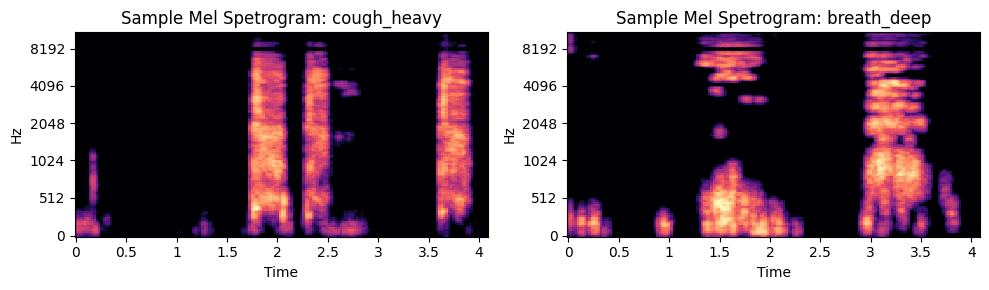

In [24]:
# Sample audio
sample_dict = {
    'cough_heavy': r'E:\project_7_summer2024\Data\Extracted_data\cough-heavy\00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav',
    'breath_deep': r'E:\project_7_summer2024\Data\Extracted_data\breathing-deep\00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav'}

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i, (key, path) in enumerate(sample_dict.items()):
    # Preprocess audio
    y, sr = librosa.load(path, sr=22000, mono=True) # Load audio file
    y_t, index = librosa.effects.trim(y, top_db=30) # Trim leading and trailing silence
    y_r = y_t[:90000] # Resize to standard length
    y_p = np.pad(y_r, (0, max(0, 90000 - len(y_r))), mode='constant') # Resize to standard length
    y_n = nr.reduce_noise(y=y_p, sr=sr, n_std_thresh_stationary=1.5, stationary=True) # Reduce noise

    # Extract features
    mel_spec = librosa.feature.melspectrogram(y=y_n, sr=sr, n_mels=128) # Apply mel scale for the frequencies
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max) # Convert into the log scale

    # Plot spectrogram
    librosa.display.specshow(log_mel_spec, x_axis='time', y_axis='mel', sr=sr, ax=axes[i])
    axes[i].set_title(f"Sample Mel Spetrogram: {key}")
    
plt.tight_layout()
plt.show()

Define preprocessing and mel feature extraction functions:

In [25]:
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=22000, mono=True) # Load audio file
    y_t, index = librosa.effects.trim(y, top_db=30) # Trim leading and trailing silence
    y_r = y_t[:90000] # Resize to standard length
    y_p = np.pad(y_r, (0, max(0, 90000 - len(y_r))), mode='constant') # Resize to standard length, pad shorter audio files with 0
    y_n = nr.reduce_noise(y=y_p, sr=sr, n_std_thresh_stationary=1.5, stationary=True) # Reduce noise
    return y_n, sr

In [26]:
def extract_mel(y, sr):
    mel_spec = librosa.feature.melspectrogram(y=y_n, sr=sr, n_mels=128) # Apply mel scale for the frequencies
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max) # Convert into the log scale
    log_mel_spec_re = cv2.resize(np.array(log_mel_spec),dsize=(128,128)) # Resize
    x = cv2.cvtColor(log_mel_spec_re, cv2.COLOR_BGR2RGB) # Color conversion
    epsilon = 1e-8 # Add a small value to avoid division by zero
    log_mel_spec_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0) + epsilon) # Min-Max normalization
    return log_mel_spec_norm

Define audio file paths

In [27]:
cough_heavy_path = r"E:\project_7_summer2024\Data\Extracted_data\cough-heavy"
breath_deep_path = r"E:\project_7_summer2024\Data\Extracted_data\breathing-deep"

**Cough Data**

Extract features for cough-heavy data:

In [28]:
cough_features_mel = []

for index_num, row in tqdm(cough_heavy_label.iterrows()):
    file = str(row['id'])
    file_path = os.path.join(os.path.abspath(cough_heavy_path),str(row['id']))

    y_n, sr = preprocess_audio(file_path) # Preprocess audio
    log_mel_spec_norm = extract_mel(y_n, sr) # Extract features
    label = row['status'] # Get corresponding label

    cough_features_mel.append([file, log_mel_spec_norm, label])

1731it [02:59,  9.67it/s]


In [29]:
# Save as df
cough_features_mel_df = pd.DataFrame(cough_features_mel, columns = ['id', 'features', 'status'])
cough_features_mel_df.head()

id   
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav  \
1  01OCEf1yB4czsq8ygRoT51s96Ba2_cough-heavy.wav   
2  05acPS4aRGfvuOfku11Za8zve8i2_cough-heavy.wav   
3  05bieNLXPuaIWEVaX81EkbbjVrh1_cough-heavy.wav   
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav   

                                            features            status  
0  [[[0.45515284, 0.45515284, 0.45515284], [0.451...    pos_asymp_mild  
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.4721545...    neg_no_illness  
2  [[[0.0011672325, 0.0011672325, 0.0011672325], ...    pos_asymp_mild  
3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    neg_no_illness  
4  [[[0.0, 0.0, 0.0], [0.20705064, 0.20705064, 0....  neg_with_illness

Label encoding:

In [30]:
cough_mel_X = np.array(cough_features_mel_df['features'].tolist())
cough_mel_Y = np.array(cough_features_mel_df['status'].tolist())

# Label encoding
labelencoder = LabelEncoder()
cough_mel_Y = to_categorical(labelencoder.fit_transform(cough_mel_Y))
print(f'Classes: {labelencoder.classes_}')

Classes: ['neg_no_illness' 'neg_with_illness' 'pos_asymp_mild' 'pos_mod']


**Breath Data**

Extract features for breathing-deep data:

In [31]:
breath_features_mel = []

for index_num, row in tqdm(breath_deep_label.iterrows()):
    file = str(row['id'])
    file_path = os.path.join(os.path.abspath(breath_deep_path),str(row['id']))

    y_n, sr = preprocess_audio(file_path) # Preprocess audio
    log_mel_spec_norm = extract_mel(y_n, sr) # Extract features
    label = row['status'] # Get corresponding label

    breath_features_mel.append([file, log_mel_spec_norm, label])

1731it [03:50,  7.52it/s]


In [32]:
# Save as df
breath_features_mel_df = pd.DataFrame(breath_features_mel, columns = ['id', 'features', 'status'])
breath_features_mel_df.head()

id   
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav  \
1  01OCEf1yB4czsq8ygRoT51s96Ba2_breathing-deep.wav   
2  05acPS4aRGfvuOfku11Za8zve8i2_breathing-deep.wav   
3  05bieNLXPuaIWEVaX81EkbbjVrh1_breathing-deep.wav   
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3_breathing-deep.wav   

                                            features            status  
0  [[[0.20749857, 0.20749857, 0.20749857], [0.261...    pos_asymp_mild  
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    neg_no_illness  
2  [[[0.1917788, 0.1917788, 0.1917788], [0.268470...    pos_asymp_mild  
3  [[[0.64646065, 0.64646065, 0.64646065], [0.477...    neg_no_illness  
4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...  neg_with_illness

Label encoding:

In [33]:
breath_mel_X = np.array(breath_features_mel_df['features'].tolist())
breath_mel_Y = np.array(breath_features_mel_df['status'].tolist())

# Label encoding
labelencoder = LabelEncoder()
breath_mel_Y = to_categorical(labelencoder.fit_transform(breath_mel_Y))
print(f'Classes: {labelencoder.classes_}')

Classes: ['neg_no_illness' 'neg_with_illness' 'pos_asymp_mild' 'pos_mod']


### 2. Mel-Frequency Cepstral Coefficients (MFCC)

Convert audio to MFCC. The following illustrates the MFCC features of sample audio signals:

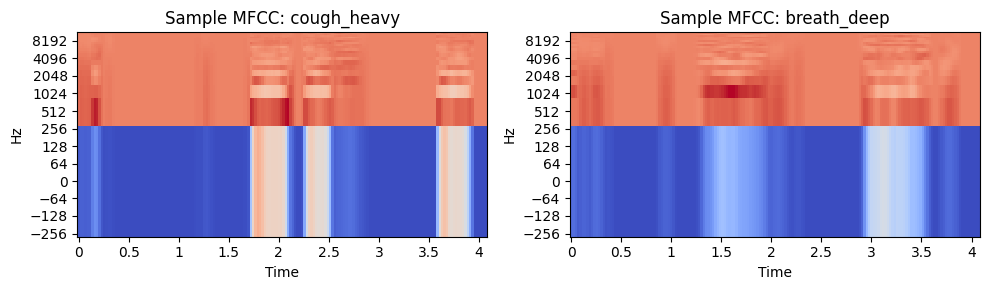

In [34]:
# Sample audio
sample_dict = {
    'cough_heavy': r'E:\project_7_summer2024\Data\Extracted_data\cough-heavy\00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav',
    'breath_deep': r'E:\project_7_summer2024\Data\Extracted_data\breathing-deep\00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav'}

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for i, (key, path) in enumerate(sample_dict.items()):
    # Preprocess audio
    y, sr = librosa.load(path, sr=22000, mono=True) # Load audio file
    y_t, index = librosa.effects.trim(y, top_db=30) # Trim leading and trailing silence
    y_r = y_t[:90000] # Resize to standard length
    y_p = np.pad(y_r, (0, max(0, 90000 - len(y_r))), mode='constant') # Resize to standard length
    y_n = nr.reduce_noise(y=y_p, sr=sr, n_std_thresh_stationary=1.5, stationary=True) # Reduce noise

    # Extract features
    mfccs = librosa.feature.mfcc(y=y_n, sr=sr)

    # Plot spectrogram
    librosa.display.specshow(mfccs, x_axis='time', y_axis='log', sr=sr, ax=axes[i])
    axes[i].set_title(f"Sample MFCC: {key}")
    
plt.tight_layout()
plt.show()

Define MFCC extraction function:

In [35]:
def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y_n, sr=sr, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc.T, axis=0)
    mfcc_re = np.array(mfcc_scaled).reshape([-1,1])
    return mfcc_re

**Cough Data**

Extract features for cough-heavy data:

In [36]:
cough_features_mfcc = []

for index_num, row in tqdm(cough_heavy_label.iterrows()):
    file = str(row['id'])
    file_path = os.path.join(os.path.abspath(cough_heavy_path),str(row['id']))

    y_n, sr = preprocess_audio(file_path) # Preprocess audio
    mfcc_re = extract_mfcc(y_n, sr) # Extract features
    label = row['status'] # Get corresponding label

    cough_features_mfcc.append([file, mfcc_re, label])

1731it [02:35, 11.16it/s]


In [37]:
# Save as df
cough_features_mfcc_df = pd.DataFrame(cough_features_mfcc, columns = ['id', 'features', 'status'])
cough_features_mfcc_df.head()

id   
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_cough-heavy.wav  \
1  01OCEf1yB4czsq8ygRoT51s96Ba2_cough-heavy.wav   
2  05acPS4aRGfvuOfku11Za8zve8i2_cough-heavy.wav   
3  05bieNLXPuaIWEVaX81EkbbjVrh1_cough-heavy.wav   
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3_cough-heavy.wav   

                                            features            status  
0  [[-574.1216], [27.83222], [-23.339808], [13.32...    pos_asymp_mild  
1  [[-436.23447], [39.39579], [-6.2789044], [-2.2...    neg_no_illness  
2  [[-638.4702], [24.764568], [-19.813526], [9.31...    pos_asymp_mild  
3  [[-483.15518], [32.863235], [-12.743891], [12....    neg_no_illness  
4  [[-498.83994], [45.12186], [-19.298288], [15.2...  neg_with_illness

Label encoding:

In [38]:
cough_mfcc_X = np.array(cough_features_mfcc_df['features'].tolist())
cough_mfcc_Y = np.array(cough_features_mfcc_df['status'].tolist())

# Label encoding
labelencoder = LabelEncoder()
cough_mfcc_Y = to_categorical(labelencoder.fit_transform(cough_mfcc_Y))
print(f'Classes: {labelencoder.classes_}')

Classes: ['neg_no_illness' 'neg_with_illness' 'pos_asymp_mild' 'pos_mod']


**Breath Data**

Extract features for breathing-deep data:

In [39]:
breath_features_mfcc = []

for index_num, row in tqdm(breath_deep_label.iterrows()):
    file = str(row['id'])
    file_path = os.path.join(os.path.abspath(breath_deep_path),str(row['id']))

    y_n, sr = preprocess_audio(file_path) # Preprocess audio
    mfcc_re = extract_mfcc(y_n, sr) # Extract features
    label = row['status'] # Get corresponding label

    breath_features_mfcc.append([file, mfcc_re, label])

1731it [03:17,  8.78it/s]


In [40]:
# Save as df
breath_features_mfcc_df = pd.DataFrame(breath_features_mfcc, columns = ['id', 'features', 'status'])
breath_features_mfcc_df.head()

id   
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2_breathing-deep.wav  \
1  01OCEf1yB4czsq8ygRoT51s96Ba2_breathing-deep.wav   
2  05acPS4aRGfvuOfku11Za8zve8i2_breathing-deep.wav   
3  05bieNLXPuaIWEVaX81EkbbjVrh1_breathing-deep.wav   
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3_breathing-deep.wav   

                                            features            status  
0  [[-864.5533], [42.867764], [38.33049], [25.419...    pos_asymp_mild  
1  [[-497.88397], [43.06512], [17.801931], [-2.08...    neg_no_illness  
2  [[-1016.5309], [62.066357], [-17.723173], [-8....    pos_asymp_mild  
3  [[-816.8551], [29.835041], [19.825287], [-6.64...    neg_no_illness  
4  [[-640.68866], [15.00303], [-13.149109], [16.7...  neg_with_illness

Label encoding:

In [41]:
breath_mfcc_X = np.array(breath_features_mfcc_df['features'].tolist())
breath_mfcc_Y = np.array(breath_features_mfcc_df['status'].tolist())

# Label encoding
labelencoder = LabelEncoder()
breath_mfcc_Y = to_categorical(labelencoder.fit_transform(breath_mfcc_Y))
print(f'Classes: {labelencoder.classes_}')

Classes: ['neg_no_illness' 'neg_with_illness' 'pos_asymp_mild' 'pos_mod']


In [42]:
# Check if order of IDs are the same for cough and breath data
cough = [file.split('_')[0] for file in cough_features_mel_df['id']]
breath = [file.split('_')[0] for file in breath_features_mfcc_df['id']]
cough == breath

True

**Metadata**

In [269]:
pd.set_option('display.max_columns', None)

Load the preprocessed metadata (from the combined_data file):

In [43]:
metadata = pd.read_csv("E:\project_7_summer2024\Data\metadata.csv")
metadata.head()

id   a  covid_status  g  l_c  l_l  l_s  smoker   
0  iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28             1  1    1    1    1     NaN  \
1  AxuYWBN0jFVLINCBqIW5aZmGCdu1  25             1  1    1    2    2     1.0   
2  C5eIsssb9GSkaAgIfsHMHeR6fSh1  28             1  2    2    3    3     NaN   
3  YjbEAECMBIaZKyfqOvWy5DDImUb2  26             1  1    1    4    2     NaN   
4  aGOvk4ji0cVqIzCs1jHnzlw2UEy2  32             1  1    1    5    4     NaN   

   cold  ht  ...  bd  others_resp  ftg  st  ihd  asthma  others_preexist  cld   
0     0   0  ...   0            0    0   0    0       0                0    0  \
1     0   0  ...   0            0    0   0    0       0                0    0   
2     0   0  ...   0            0    0   0    0       0                0    0   
3     1   0  ...   0            0    0   0    0       0                0    0   
4     0   0  ...   0            0    0   0    0       0                0    0   

   pneumonia            status  
0          0    neg_no_illness  
1          0    neg_no_illness  
2          0    neg_no_illness  
3          0  neg_with_illness  
4          0    neg_no_illness  

[5 rows x 32 columns]

Retain metadata for the 1731 respondents to match the cough and breathing audio samples:

In [44]:
meta = metadata[metadata['id'].isin(common_id)]
meta.head()

id   a  covid_status  g  l_c  l_l  l_s  smoker   
0  iV3Db6t1T8b7c5HQY2TwxIhjbzD3  28             1  1    1    1    1     NaN  \
1  AxuYWBN0jFVLINCBqIW5aZmGCdu1  25             1  1    1    2    2     1.0   
2  C5eIsssb9GSkaAgIfsHMHeR6fSh1  28             1  2    2    3    3     NaN   
3  YjbEAECMBIaZKyfqOvWy5DDImUb2  26             1  1    1    4    2     NaN   
4  aGOvk4ji0cVqIzCs1jHnzlw2UEy2  32             1  1    1    5    4     NaN   

   cold  ht  ...  bd  others_resp  ftg  st  ihd  asthma  others_preexist  cld   
0     0   0  ...   0            0    0   0    0       0                0    0  \
1     0   0  ...   0            0    0   0    0       0                0    0   
2     0   0  ...   0            0    0   0    0       0                0    0   
3     1   0  ...   0            0    0   0    0       0                0    0   
4     0   0  ...   0            0    0   0    0       0                0    0   

   pneumonia            status  
0          0    neg_no_illness  
1          0    neg_no_illness  
2          0    neg_no_illness  
3          0  neg_with_illness  
4          0    neg_no_illness  

[5 rows x 32 columns]

Reorder metadata rows to match order of audio files:

In [46]:
meta = meta.set_index('id').reindex(cough).reset_index()
meta.head()

id   a  covid_status  g  l_c  l_l  l_s  smoker   
0  00xKcQMmcAhX8CODgBBLOe7Dm0T2  24             6  2    1  186   20     NaN  \
1  01OCEf1yB4czsq8ygRoT51s96Ba2  27             1  2    1  133    2     NaN   
2  05acPS4aRGfvuOfku11Za8zve8i2  22             6  1    1  140    2     NaN   
3  05bieNLXPuaIWEVaX81EkbbjVrh1  19             1  2    1   11    2     NaN   
4  0bcMNFt3dlPlUPTyCO8DVAlbTUC3  58             1  1    1  576    1     2.0   

   cold  ht  ...  bd  others_resp  ftg  st  ihd  asthma  others_preexist  cld   
0     0   0  ...   0            0    1   0    0       0                0    0  \
1     0   0  ...   0            0    0   0    0       0                0    0   
2     1   0  ...   0            0    0   1    0       0                0    0   
3     0   0  ...   0            0    0   0    0       0                0    0   
4     0   1  ...   0            0    0   0    1       0                0    0   

   pneumonia            status  
0          0    pos_asymp_mild  
1          0    neg_no_illness  
2          0    pos_asymp_mild  
3          0    neg_no_illness  
4          0  neg_with_illness  

[5 rows x 32 columns]

Label encoding:

In [47]:
meta_X = meta.drop(['status', 'id'], axis=1).values
meta_Y = np.array(meta['status'].values.tolist())

# Label encoding
labelencoder = LabelEncoder()
meta_Y = to_categorical(labelencoder.fit_transform(meta_Y))
print(f'Classes: {labelencoder.classes_}')

Classes: ['neg_no_illness' 'neg_with_illness' 'pos_asymp_mild' 'pos_mod']


In [48]:
meta['status'].value_counts()

status
neg_no_illness      1028
pos_asymp_mild       374
neg_with_illness     233
pos_mod               96
Name: count, dtype: int64

## <a id='individualmodels'></a> E. Model Training and Evaluation - Individual Models

The following codes are only used to test individual models. Proceed to next section for concatenated model.

### 1. Mel Spectrogram

#### Build Model

Results from the study by Effati (2023) on autonomous detection of COVID-19 symptoms using cough and breathing showed that DenseNet-201 achieved the highest unimodal and multimodal classification performance compared to the other  neural networks.

The pretrained DenseNet-201 model will be used here:

In [49]:
def build_mel_audio_model():
    base_model = DenseNet201(input_shape=(128,128,3), include_top=False, weights='imagenet', pooling='avg')
    base_model.trainable = False
    x = base_model.output
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(4, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [94]:
mel_model = build_mel_audio_model()
mel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.summary()

#### Train Model

**Cough Data**

Split training data into training (80%) and validation (20%):

In [95]:
cough_train_mel_x, cough_val_mel_x, cough_train_mel_y, cough_val_mel_y = train_test_split(
    cough_train_mel_X, cough_train_mel_Y, test_size=0.2, random_state=7)

In [96]:
hist = mel_model.fit(cough_train_mel_x, cough_train_mel_y, epochs=5, validation_data=(cough_val_mel_x, cough_val_mel_y), shuffle=True)

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.3448 - loss: 1.7167 - val_accuracy: 0.5008 - val_loss: 1.1787
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.5077 - loss: 1.1704 - val_accuracy: 0.5832 - val_loss: 1.0939
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.5834 - loss: 1.0226 - val_accuracy: 0.5880 - val_loss: 1.1220
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.6124 - loss: 0.9642 - val_accuracy: 0.5767 - val_loss: 1.0934
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.6041 - loss: 0.9320 - val_accuracy: 0.5945 - val_loss: 1.1358


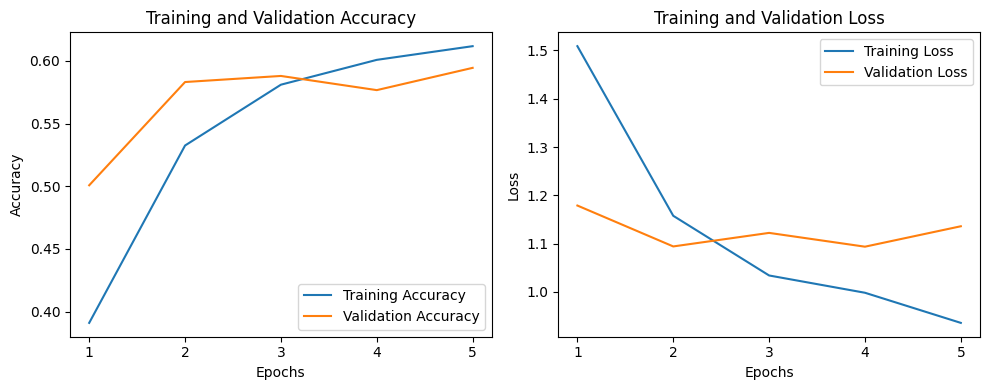

In [98]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(accuracy) + 1) 

plt.figure(figsize=(10, 4))

# Training and validation accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(1, len(accuracy) + 1, 1))

# Training and validation loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.xticks(range(1, len(accuracy) + 1, 1))

plt.tight_layout()
plt.show()


#### Evaluate Model

**Classification Report**

In [144]:
# Predict using test data
pred = mel_model.predict(cough_test_mel_X)
y_pred = np.argmax(pred, axis=1)

y_true = np.argmax(cough_test_mel_Y, axis=1)

# Retrieve original class names
class_names = labelencoder.classes_

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step
                  precision    recall  f1-score   support

  neg_no_illness     0.6068    0.9428    0.7384       437
neg_with_illness     0.0000    0.0000    0.0000        96
  pos_asymp_mild     0.4667    0.2515    0.3268       167
         pos_mod     0.0000    0.0000    0.0000        74

        accuracy                         0.5866       774
       macro avg     0.2684    0.2986    0.2663       774
    weighted avg     0.4433    0.5866    0.4874       774



**Accuracy**

In [145]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

Accuracy: 0.58656330749354


**Confusion Matrix**

<Axes: >

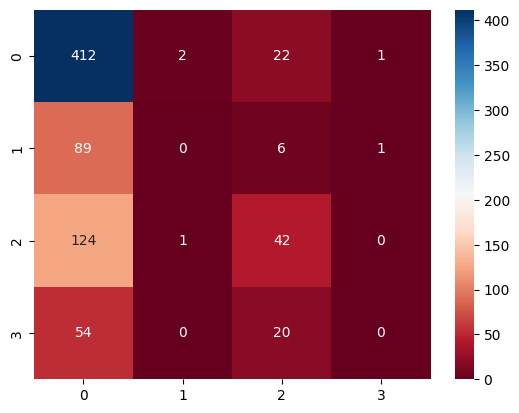

In [155]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu')

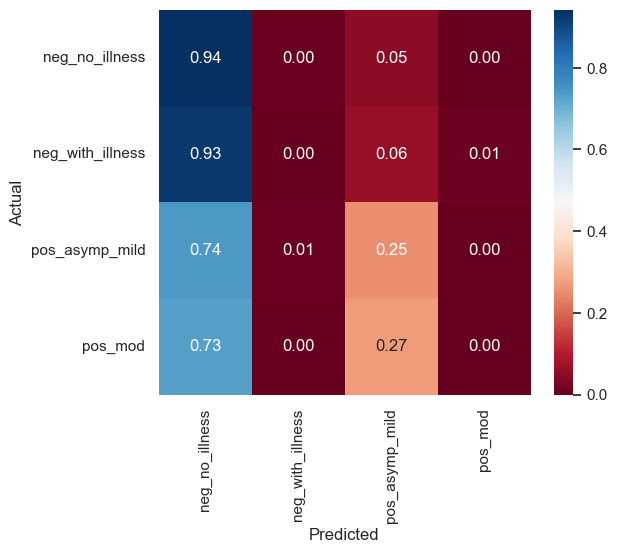

In [208]:
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalise
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='RdBu', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

**ROC Curve and AUC**

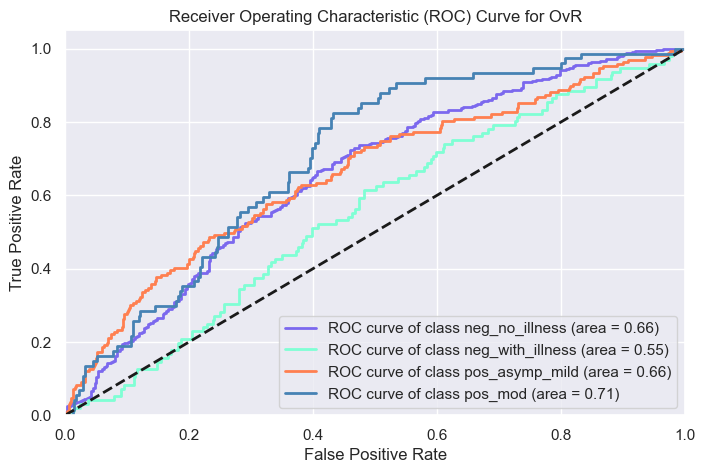

In [184]:
# Binarize true labels
y_true_binary = label_binarize(cough_test_mel_Y, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class, use OVR (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 5))
sns.set(style='darkgrid')
colors = ['mediumslateblue', 'aquamarine', 'coral', 'steelblue']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for OvR')
plt.legend(loc="lower right")
plt.show()

### 2. Mel-Frequency Cepstral Coefficients (MFCC)

Split training data into training (80%) and validation (20%):

In [261]:
cough_train_mfcc_x, cough_val_mfcc_x, cough_train_mfcc_y, cough_val_mfcc_y = train_test_split(
    cough_train_mfcc_X, cough_train_mfcc_Y, test_size=0.2, random_state=7)

#### Build Model

In [265]:
def build_mfcc_audio_model():
    model= models.Sequential()
    model.add(layers.Input(shape=(40,1)))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='softmax'))
    return model 

In [266]:
mfcc_model = build_mfcc_audio_model()
mfcc_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# mfcc_model.summary()

#### Train Model

**Cough Data**

In [267]:
hist_mfcc = mfcc_model.fit(cough_train_mfcc_x, cough_train_mfcc_y, epochs=5, validation_data=(cough_val_mfcc_x, cough_val_mfcc_y), shuffle=True)

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5343 - loss: 1.1602 - val_accuracy: 0.5751 - val_loss: 1.0897
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5411 - loss: 1.1181 - val_accuracy: 0.5816 - val_loss: 1.0865
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5455 - loss: 1.0947 - val_accuracy: 0.5751 - val_loss: 1.0890
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5420 - loss: 1.0993 - val_accuracy: 0.5751 - val_loss: 1.0893
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5509 - loss: 1.0988 - val_accuracy: 0.5767 - val_loss: 1.0857


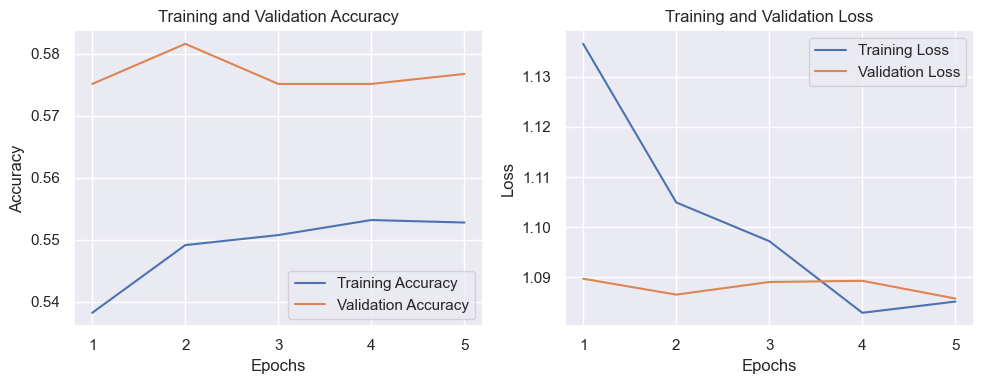

In [268]:
accuracy = hist_mfcc.history['accuracy']
val_accuracy = hist_mfcc.history['val_accuracy']

loss = hist_mfcc.history['loss']
val_loss = hist_mfcc.history['val_loss']

epochs = range(1, len(accuracy) + 1) 

plt.figure(figsize=(10, 4))

# Training and validation accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(1, len(accuracy) + 1, 1))

# Training and validation loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.xticks(range(1, len(accuracy) + 1, 1))

plt.tight_layout()
plt.show()


#### Evaluate Model

**Classification Report**

In [269]:
# Predict using test data
pred = mfcc_model.predict(cough_test_mfcc_X)
y_pred = np.argmax(pred, axis=1)

y_true = np.argmax(cough_test_mfcc_Y, axis=1)

# Retrieve original class names
class_names = labelencoder.classes_

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
                  precision    recall  f1-score   support

  neg_no_illness     0.5671    0.9954    0.7226       437
neg_with_illness     0.0000    0.0000    0.0000        96
  pos_asymp_mild     0.4286    0.0180    0.0345       167
         pos_mod     0.0000    0.0000    0.0000        74

        accuracy                         0.5659       774
       macro avg     0.2489    0.2533    0.1893       774
    weighted avg     0.4127    0.5659    0.4154       774



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [270]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

Accuracy: 0.5658914728682171


**Confusion Matrix**

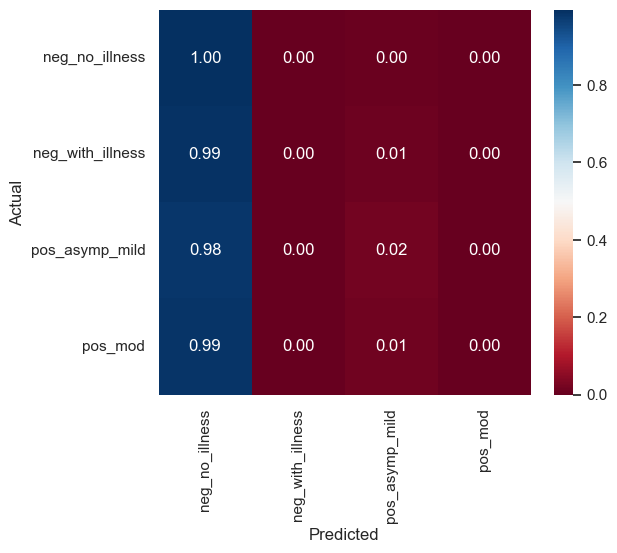

In [271]:
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalise
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='RdBu', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

**ROC Curve and AUC**

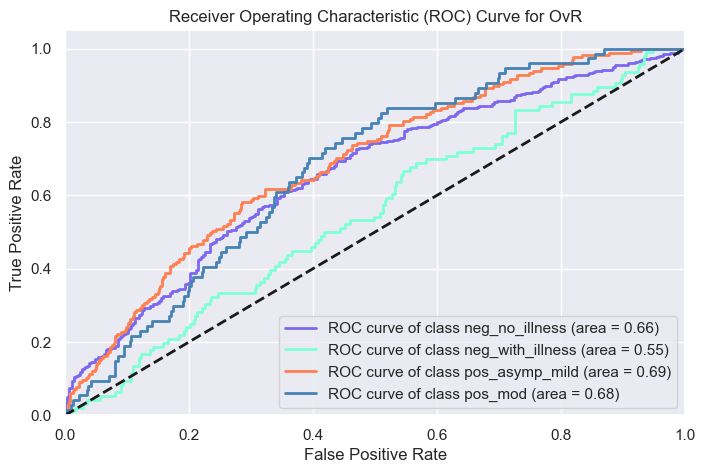

In [272]:
# Binarize true labels
y_true_binary = label_binarize(cough_test_mfcc_Y, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class, use OVR (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 5))
sns.set(style='darkgrid')
colors = ['mediumslateblue', 'aquamarine', 'coral', 'steelblue']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for OvR')
plt.legend(loc="lower right")
plt.show()

## <a id='multimodalmodels'></a> F. Model Training and Evaluation - Multimodal Models

**Split train (80%) and test (20%) data**

***Audio data***

In [50]:
# Check if y values are the same for all input data
print(np.array_equal(cough_mel_Y, breath_mfcc_Y))
print(np.array_equal(cough_mel_Y, meta_Y))

True
True


In [51]:
# Split train and test data 
(cough_mel_X_train, cough_mel_X_test,
 cough_mel_Y_train, cough_mel_Y_test,
 breath_mfcc_X_train, breath_mfcc_X_test,
 breath_mfcc_Y_train, breath_mfcc_Y_test,
 meta_X_train, meta_X_test,
 meta_Y_train, meta_Y_test,) = train_test_split(
    cough_mel_X, cough_mel_Y,
    breath_mfcc_X, breath_mfcc_Y,
    meta_X, meta_Y,
    test_size=0.2, random_state=7)

In [52]:
# Check the shape of train data
print(f'cough_mel_X_train shape: {cough_mel_X_train.shape}')
print(f'breath_mfcc_X_train shape: {breath_mfcc_X_train.shape}')
print(f'meta_X_train shape: {meta_X_train.shape}')

cough_mel_X_train shape: (1384, 128, 128, 3)
breath_mfcc_X_train shape: (1384, 40, 1)
meta_X_train shape: (1384, 30)


In [53]:
# Check the shape of test data
print(f'cough_mel_X_test shape: {cough_mel_X_test.shape}')
print(f'breath_mfcc_X_test shape: {breath_mfcc_X_test.shape}')
print(f'meta_X_test shape: {meta_X_test.shape}')

cough_mel_X_test shape: (347, 128, 128, 3)
breath_mfcc_X_test shape: (347, 40, 1)
meta_X_test shape: (347, 30)


#### Build Model

**CNN Model**

*Model to be used for the Mel spectrogram features of the cough-heavy audio samples*

In [54]:
def build_mel_audio_model():
    base_model = DenseNet201(input_shape=(128,128,3), include_top=False, weights='imagenet', pooling='avg')
    base_model.trainable = False
    x = base_model.output
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(4, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    return model

**LSTM Model**

*Model to be used for the MFCC features of the breathing-deep audio samples*

In [55]:
def build_mfcc_audio_model():
    input_layer = layers.Input(shape=(40, 1))
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_layer)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    predictions = layers.Dense(4, activation='softmax')(x)
    model = models.Model(inputs=input_layer, outputs=predictions)
    return model

**Meta Model**

*Model to be used for the metada*

In [56]:
def build_meta_densenet_model():
    inputs = layers.Input(shape=(30,))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

**Concatenated Model**

In [57]:
mel_model = build_mel_audio_model()
mfcc_model = build_mfcc_audio_model()
meta_model = build_meta_densenet_model()

merge = layers.concatenate([mel_model.output, mfcc_model.output, meta_model.output])
x = layers.Dense(64, activation='relu')(merge)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(4, activation="softmax")(x)

model = models.Model(inputs = [mel_model.input, mfcc_model.input, meta_model.input], outputs = output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train Model

Train concatenated model:

In [59]:
hist = model.fit(x=[cough_mel_X_train, breath_mfcc_X_train, meta_X_train], y=meta_Y_train,
                 validation_split=0.2,
                 class_weight = {0: 1.0, 1: 4.0, 2: 3.0, 3: 10.0},
                 epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2815 - loss: 3.5152 - val_accuracy: 0.6318 - val_loss: 1.2738
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.2863 - loss: 3.4160 - val_accuracy: 0.6318 - val_loss: 1.2566
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3207 - loss: 3.3322 - val_accuracy: 0.6282 - val_loss: 1.2842
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3056 - loss: 3.1428 - val_accuracy: 0.5776 - val_loss: 1.2901
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3194 - loss: 3.1414 - val_accuracy: 0.6101 - val_loss: 1.2551
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3989 - loss: 2.7637 - val_accuracy: 0.4260 - val_loss: 1.2782
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3522 - loss: 2.7383 - val_accuracy: 0.4043 - val_loss: 1.2372
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3602 - loss: 2.6367 - val_accuracy: 0.3646 - v

Training and validation accuracy:

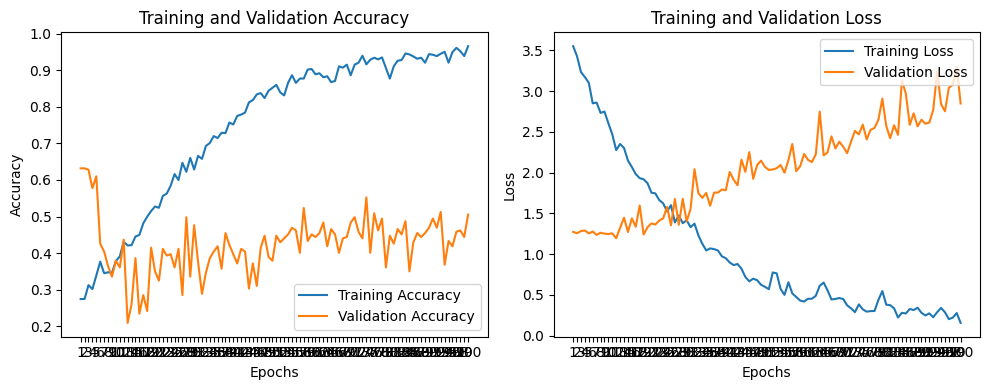

In [60]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(accuracy) + 1) 

plt.figure(figsize=(10, 4))

# Training and validation accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(1, len(accuracy) + 1, 1))

# Training and validation loss
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.xticks(range(1, len(accuracy) + 1, 1))

plt.tight_layout()
plt.show()


#### Evaluate Model

**Classification Report**

In [61]:
# Predict using test data
pred = model.predict([cough_mel_X_test, breath_mfcc_X_test, meta_X_test])
y_pred = np.argmax(pred, axis=1)

y_true = np.argmax(meta_Y_test, axis=1)

# Retrieve original class names
class_names = labelencoder.classes_

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
                  precision    recall  f1-score   support

  neg_no_illness     0.6606    0.6792    0.6698       212
neg_with_illness     0.2000    0.1778    0.1882        45
  pos_asymp_mild     0.3014    0.3492    0.3235        63
         pos_mod     0.1875    0.1111    0.1395        27

        accuracy                         0.5101       347
       macro avg     0.3374    0.3293    0.3303       347
    weighted avg     0.4988    0.5101    0.5032       347



In [62]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

Accuracy: 0.5100864553314121


**Confusion Matrix**

<Axes: >

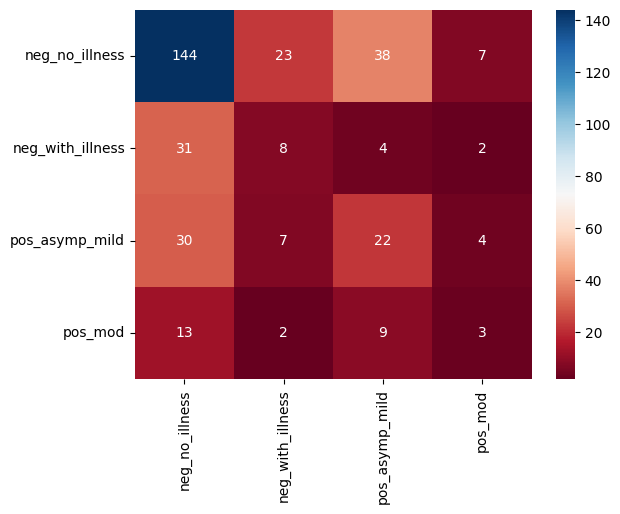

In [63]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='RdBu', fmt='d', xticklabels=class_names, yticklabels=class_names)

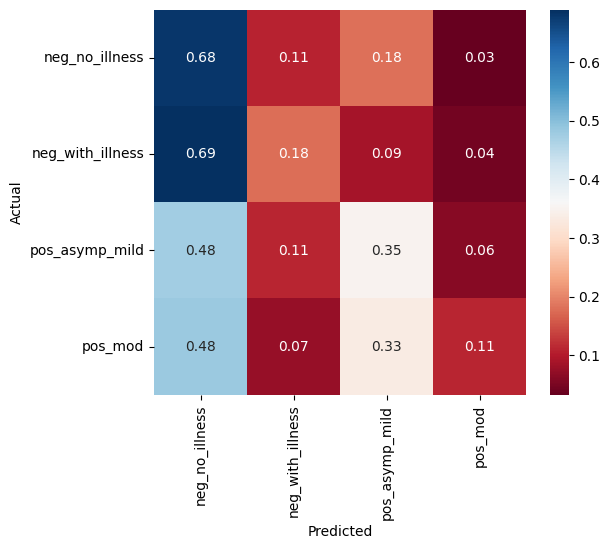

In [64]:
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalise
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='RdBu', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

**ROC Curve and AUC**

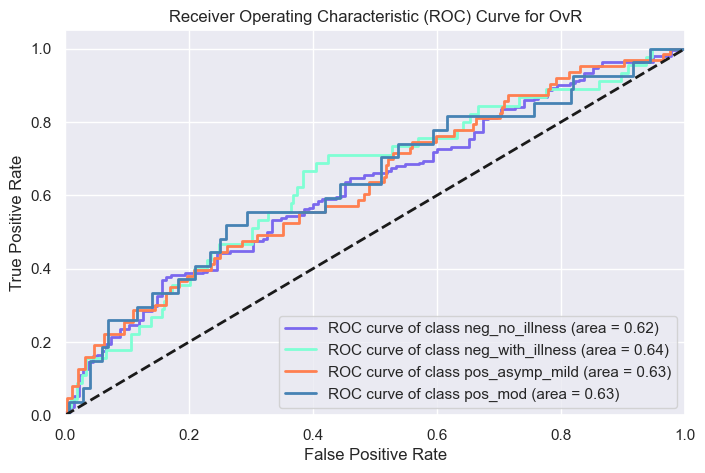

In [65]:
# Binarize true labels
y_true_binary = label_binarize(meta_Y_test, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class, use OVR (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 5))
sns.set(style='darkgrid')
colors = ['mediumslateblue', 'aquamarine', 'coral', 'steelblue']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for OvR')
plt.legend(loc="lower right")
plt.show()